### Project Description 

This project aims to predict customer churn for the telecom operator Interconnect. Using datasets on contracts, personal information, internet, and phone services, the goal is to identify clients likely to leave the company. The target variable is derived from the EndDate column, with 'No' indicating active customers and any other value indicating churn. The workflow includes exploratory data analysis, preprocessing, feature engineering, handling class imbalance, and training machine learning models, including a dummy baseline and advanced classifiers such as Logistic Regression, Random Forest, and XGBoost. The primary evaluation metric is AUC-ROC, with accuracy as a secondary metric. The final model will help the marketing team proactively retain clients.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

### Load Data

In [2]:
contract_df = pd.read_csv('/datasets/final_provider/contract.csv')
personal_df = pd.read_csv('/datasets/final_provider/personal.csv')
internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
phone_df = pd.read_csv('/datasets/final_provider/phone.csv')

### DATA Preprocessing

In [3]:
data_dict = {
    "contract": contract_df,
    "personal": personal_df,
    "internet": internet_df,
    "phone": phone_df
}

for name, df in data_dict.items():
    print("-" * 50)
    print(f"{name.upper()} DATAFRAME")
    print("-" * 50)
    
    # Basic info
    df.info()
    
    # Show first few rows
    display(df.head())
    
    # Count duplicate rows
    print(f"Duplicate Rows: {df.duplicated().sum()}")

--------------------------------------------------
CONTRACT DATAFRAME
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Duplicate Rows: 0
--------------------------------------------------
PERSONAL DATAFRAME
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Duplicate Rows: 0
--------------------------------------------------
INTERNET DATAFRAME
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Duplicate Rows: 0
--------------------------------------------------
PHONE DATAFRAME
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Duplicate Rows: 0


### Initial Thoughts

Since all of the dataframes contain the unique customerID I will merge them into one dataset.The columns with "yes" and "no" will be replaced with 0s and 1s. Any missing value will be replaced with 0s. I will also add a "Churn" column to the dataset as that is my target. 

### Merging Datasets

In [4]:
merged_df = contract_df.copy()

for df in [personal_df, internet_df, phone_df]:
    merged_df = merged_df.merge(df, on="customerID", how="left")

In [5]:
print(display(merged_df.sample(10)))
print(merged_df.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
7018,1122-JWTJW,2019-10-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,70.65,70.65,Male,0,Yes,Yes,Fiber optic,No,No,No,No,No,No,No
6355,1936-UAFEH,2014-06-01,No,Two year,No,Credit card (automatic),110.25,7279.35,Female,0,No,No,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Yes
2423,1133-KXCGE,2018-08-01,No,One year,No,Mailed check,20.10,407.05,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
510,4332-MUOEZ,2018-06-01,No,One year,No,Credit card (automatic),94.30,1818.3,Male,1,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,No,Yes,No
1126,0927-LCSMG,2019-06-01,2020-01-01 00:00:00,Month-to-month,No,Mailed check,74.65,544.55,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
244,4522-AKYLR,2019-01-01,No,Month-to-month,Yes,Electronic check,54.80,731.3,Female,1,No,No,DSL,No,Yes,Yes,No,No,No,No
5092,5774-XZTQC,2019-07-01,No,Month-to-month,No,Mailed check,20.45,150.75,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2929,2606-PKWJB,2016-10-01,No,One year,No,Mailed check,40.25,1564.05,Male,0,No,Yes,DSL,Yes,Yes,No,Yes,No,No,NaN
2887,5696-QURRL,2019-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Mailed check,45.05,45.05,Male,0,No,No,DSL,No,No,No,No,No,No,No
2393,5136-KCKGI,2017-02-01,2019-11-01 00:00:00,One year,Yes,Mailed check,103.70,3467,Female,0,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Yes


None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   obj

### Converting columns with Yes and No to 1s and 0s

In [6]:
yes_no_cols = ["PaperlessBilling", 
               "Partner", 
               "Dependents",
               "OnlineSecurity",
               "OnlineBackup",
               "DeviceProtection",
               "TechSupport",
               "StreamingTV",
               "StreamingMovies",
               "MultipleLines"
              ]

# First, map Yes/No to 1/0, then fill NaN with 0
merged_df[yes_no_cols] = (
    merged_df[yes_no_cols]
        .replace({"Yes": 1, "No": 0})  # Map text to numbers first
        .fillna(0)                     # Fill missing values with 0
        .astype("int64")               # Now convert to integers
)
display(merged_df.sample(10))
print(merged_df.info(0))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
1234,4525-VZCZG,2015-08-01,No,One year,1,Electronic check,105.85,5826.65,Male,0,0,1,Fiber optic,1,1,0,1,1,1,0
4227,5457-COLHT,2014-05-01,No,Two year,0,Bank transfer (automatic),80.65,5542.55,Male,0,1,1,DSL,1,1,0,1,1,1,0
2951,5815-HGGHV,2018-06-01,No,One year,1,Mailed check,64.15,1274.45,Male,0,1,0,DSL,1,0,0,1,0,1,0
392,0224-RLWWD,2019-12-01,No,Month-to-month,1,Electronic check,44.30,89.3,Female,1,0,0,DSL,0,0,0,0,0,0,0
3419,1063-DHQJF,2014-05-01,No,Two year,1,Mailed check,92.15,6480.9,Male,0,1,1,Fiber optic,0,1,0,1,1,0,0
817,0036-IHMOT,2015-07-01,No,One year,1,Bank transfer (automatic),103.70,5656.75,Female,0,1,1,Fiber optic,0,1,1,1,1,1,0
5112,1383-EZRWL,2019-06-01,2020-01-01 00:00:00,Month-to-month,0,Mailed check,20.05,164.85,Female,0,0,0,NaN,0,0,0,0,0,0,0
3880,9470-RTWDV,2017-12-01,No,One year,1,Credit card (automatic),82.00,2083.1,Male,0,1,1,DSL,0,0,1,1,1,1,1
5430,6331-LWDTQ,2019-02-01,2019-12-01 00:00:00,Month-to-month,1,Credit card (automatic),72.15,794.25,Male,0,0,0,DSL,0,0,0,0,1,1,1
1678,1060-ENTOF,2014-07-01,No,One year,1,Credit card (automatic),105.40,7035.6,Female,1,1,0,Fiber optic,1,1,1,1,0,1,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   int64  
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   int64  
 11  Dependents        7043 non-null   int64  
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    7043 non-null   int64  
 14  OnlineBackup      7043 non-null   int64  
 15  DeviceProtection  7043 non-null   int64  
 16  TechSupport       7043 non-null   int64  


### Filling Internet Service column with 'None'

In [7]:
merged_df['InternetService'] = merged_df['InternetService'].fillna('None')
print(display(merged_df.sample(10)))
print(merged_df.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
1841,8958-JPTRR,2015-06-01,No,One year,0,Electronic check,24.30,1261.7,Female,0,1,0,None,0,0,0,0,0,0,1
2100,6227-FBDXH,2014-05-01,No,One year,0,Bank transfer (automatic),99.50,6841.45,Male,0,1,0,Fiber optic,0,0,1,0,1,1,1
2939,8802-UNOJF,2018-12-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,83.80,1029.75,Male,1,0,0,Fiber optic,0,1,1,1,0,0,0
1663,5364-XYIRR,2015-07-01,2019-10-01 00:00:00,Month-to-month,1,Electronic check,94.65,4812.75,Male,0,1,0,Fiber optic,0,0,0,0,1,1,1
5201,6202-JVYEU,2019-05-01,No,One year,1,Electronic check,19.90,164.6,Male,0,0,0,None,0,0,0,0,0,0,0
5547,9611-CTWIH,2019-10-01,2020-01-01 00:00:00,Month-to-month,1,Electronic check,89.45,240.45,Female,0,0,0,Fiber optic,0,0,0,0,1,1,0
6882,8065-QBYTO,2014-03-01,No,One year,1,Credit card (automatic),99.65,7181.25,Female,1,0,0,Fiber optic,1,1,0,1,1,0,1
6214,6725-TPKJO,2016-06-01,No,Two year,0,Mailed check,20.05,845.25,Male,0,0,0,None,0,0,0,0,0,0,0
1170,9127-FHJBZ,2014-02-01,No,Two year,1,Electronic check,114.00,8093.15,Male,0,1,1,Fiber optic,1,1,1,1,1,1,1
5784,7401-RUBNK,2018-08-01,No,Month-to-month,0,Electronic check,74.80,1438.05,Female,0,1,0,Fiber optic,1,0,0,0,0,0,0


None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   int64  
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   int64  
 11  Dependents        7043 non-null   int64  
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   int64  
 14  OnlineBackup      7043 non-null   int64  
 15  DeviceProtection  7043 non-null   int64  
 16  TechSupport       7043 non-null   int

### Creating Target Column 'Churned'

In [8]:
merged_df['Churned'] = merged_df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)
display(merged_df.sample(10))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Churned
5072,5995-SNNEW,2018-03-01,No,Month-to-month,1,Electronic check,104.45,2184.85,Male,1,...,0,Fiber optic,0,1,1,0,1,1,1,0
1781,2519-LBNQL,2015-02-01,No,One year,1,Electronic check,104.35,6339.45,Male,1,...,0,Fiber optic,0,1,1,0,1,1,1,0
1304,8519-IMDHU,2018-09-01,2019-12-01 00:00:00,Month-to-month,1,Bank transfer (automatic),85.60,1345.55,Male,1,...,0,Fiber optic,0,0,0,0,0,1,1,1
1477,5469-CTCWN,2014-12-01,2020-01-01 00:00:00,One year,1,Electronic check,106.00,6547.7,Male,0,...,1,Fiber optic,1,1,0,0,1,1,1,1
6952,6394-MFYNG,2015-10-01,2019-10-01 00:00:00,Month-to-month,1,Bank transfer (automatic),107.40,5121.3,Female,0,...,0,Fiber optic,0,1,1,0,1,1,1,1
3721,2839-RFSQE,2019-11-01,2020-01-01 00:00:00,Month-to-month,0,Mailed check,20.65,38.7,Female,0,...,0,None,0,0,0,0,0,0,0,1
2175,7927-AUXBZ,2017-07-01,2020-01-01 00:00:00,Month-to-month,0,Electronic check,85.15,2555.9,Female,0,...,0,Fiber optic,0,0,0,1,1,0,0,1
6194,2868-LLSKM,2014-06-01,No,One year,1,Bank transfer (automatic),83.65,5733.4,Female,0,...,1,Fiber optic,0,1,0,1,0,0,1,0
3326,7657-DYEPJ,2016-11-01,2020-01-01 00:00:00,One year,1,Credit card (automatic),70.15,2497.35,Male,1,...,0,DSL,0,1,1,1,1,0,0,1
4720,8979-CAMGB,2014-10-01,No,One year,0,Electronic check,102.10,6688.1,Male,1,...,0,Fiber optic,0,0,1,1,1,1,1,0


### Checking for class imbalance

In [9]:
merged_df['Churned'].value_counts(normalize=True) * 100

0    73.463013
1    26.536987
Name: Churned, dtype: float64

### Converting 'EndDate' into datetime

In [10]:
merged_df['EndDate_dt'] = pd.to_datetime(merged_df['EndDate'], errors='coerce')
print(merged_df[['EndDate', 'EndDate_dt', 'Churned']].sample(10))
churned_df = merged_df[merged_df['EndDate_dt'].notna()].copy()
churned_df['churn_month'] = churned_df['EndDate_dt'].dt.month

                  EndDate EndDate_dt  Churned
4225                   No        NaT        0
584                    No        NaT        0
3406                   No        NaT        0
2592                   No        NaT        0
5453                   No        NaT        0
3482                   No        NaT        0
5280                   No        NaT        0
6425                   No        NaT        0
3334  2019-11-01 00:00:00 2019-11-01        1
1136                   No        NaT        0


In [11]:
print(display(churned_df.sample(10)))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Churned,EndDate_dt,churn_month
5428,7394-FKDNK,2019-02-01,2019-11-01 00:00:00,Month-to-month,0,Electronic check,89.45,853.1,Female,0,...,0,0,0,0,1,1,0,1,2019-11-01,11
1834,8080-DDEMJ,2019-12-01,2020-01-01 00:00:00,Month-to-month,0,Electronic check,45.10,45.1,Male,1,...,0,0,0,0,0,0,0,1,2020-01-01,1
383,5167-ZFFMM,2019-10-01,2019-11-01 00:00:00,Month-to-month,1,Credit card (automatic),90.85,90.85,Male,0,...,0,1,0,0,0,1,1,1,2019-11-01,11
2607,5539-TMZLF,2019-12-01,2020-01-01 00:00:00,Month-to-month,1,Electronic check,69.75,69.75,Male,1,...,0,0,0,0,0,0,0,1,2020-01-01,1
6716,9850-OWRHQ,2019-09-01,2019-12-01 00:00:00,Month-to-month,1,Credit card (automatic),74.10,228,Female,0,...,0,0,0,0,0,0,1,1,2019-12-01,12
3617,3346-BRMIS,2018-06-01,2019-12-01 00:00:00,Month-to-month,1,Electronic check,48.35,810.7,Female,1,...,0,0,1,0,1,1,0,1,2019-12-01,12
6197,1585-MQSSU,2018-08-01,2020-01-01 00:00:00,Month-to-month,0,Mailed check,51.50,900.5,Male,0,...,0,0,0,1,0,0,0,1,2020-01-01,1
4062,1915-IOFGU,2019-11-01,2019-12-01 00:00:00,Month-to-month,0,Electronic check,70.50,70.5,Female,0,...,0,0,0,0,0,0,0,1,2019-12-01,12
5888,8610-WFCJF,2015-11-01,2019-12-01 00:00:00,Month-to-month,1,Electronic check,95.60,4783.5,Female,0,...,0,0,0,0,1,1,1,1,2019-12-01,12
3245,0461-CVKMU,2017-11-01,2019-10-01 00:00:00,Month-to-month,0,Electronic check,83.80,1900.25,Female,0,...,0,1,1,1,0,0,0,1,2019-10-01,10


None


### Clarifying Questions

1) What is the overall churn rate, and how imbalanced is the target variable?

2) Which customer characteristics (e.g., contract type, tenure, payment method) show the strongest relationship with churn?

3) Are there noticeable differences in churn rates across internet service types (DSL, Fiber Optic, None)?

4) What is the churn rate by gender?

5) Does the payment method affect the churn rate?

### Churned and active customers per contract type

Churned,0,1
Type,,
Month-to-month,2220,1655
One year,1307,166
Two year,1647,48


None


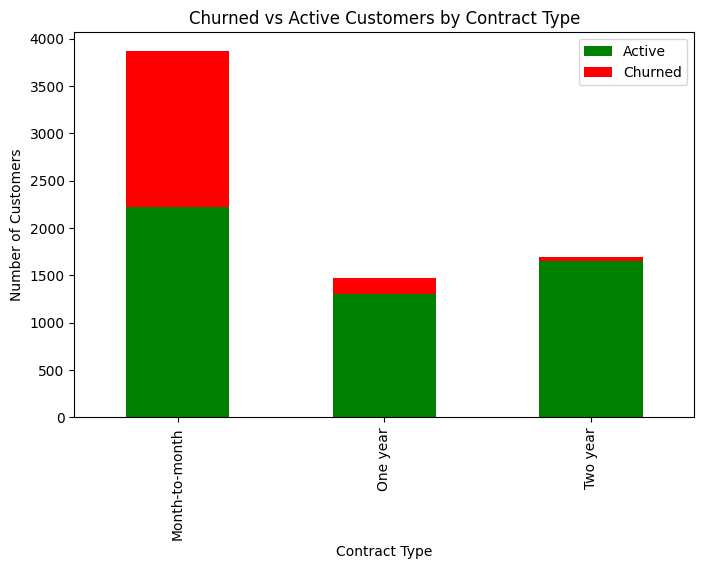

In [12]:
churn_counts = merged_df.groupby(['Type', 'Churned']).size().unstack(fill_value=0)
print(display(churn_counts))
churn_counts.plot(
    kind='bar',
    stacked=True,
    color=['green', 'red'],  # optional: red = churned, green = active
    figsize=(8,5)
)

plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.title('Churned vs Active Customers by Contract Type')
plt.legend(['Active', 'Churned'])
plt.show()

### Churned and active customers by InternetService

Churned,0,1
InternetService,,
DSL,1962,459
Fiber optic,1799,1297
None,1413,113


None


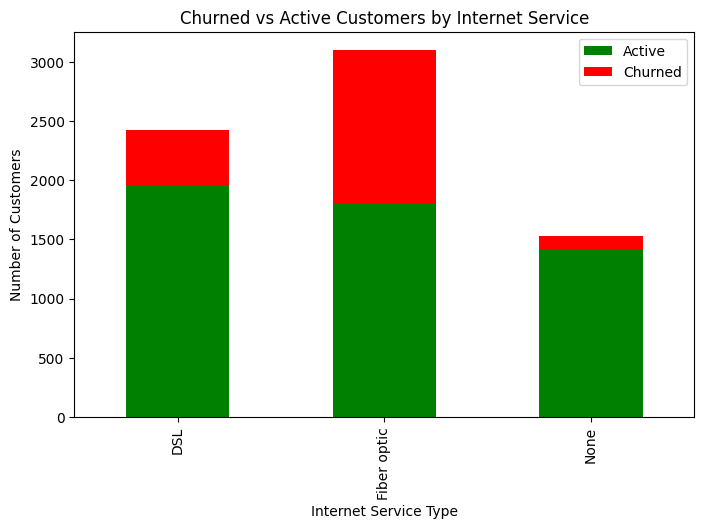

In [13]:
churn_counts_2 = merged_df.groupby(['InternetService', 'Churned']).size().unstack(fill_value=0)
print(display(churn_counts_2))
# Plot stacked bar chart
churn_counts_2.plot(
    kind='bar',
    stacked=True,
    color=['green', 'red'],  # red = churned, green = active
    figsize=(8,5)
)

plt.xlabel('Internet Service Type')
plt.ylabel('Number of Customers')
plt.title('Churned vs Active Customers by Internet Service')
plt.legend(['Active', 'Churned'])
plt.show()

### Churned and active customers by Gender

Churned,0,1
gender,,
Female,2549,939
Male,2625,930


None


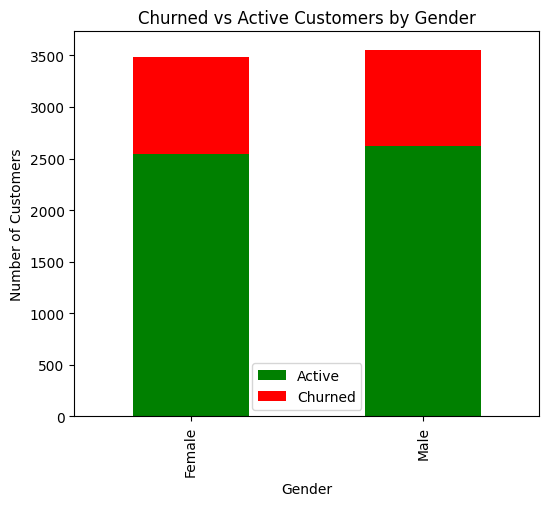

In [14]:
churn_counts_gender = merged_df.groupby(['gender', 'Churned']).size().unstack(fill_value=0)
print(display(churn_counts_gender))
churn_counts_gender.plot(
    kind='bar',
    stacked=True,
    color=['green', 'red'],  # red = churned, green = active
    figsize=(6,5)
)

plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.title('Churned vs Active Customers by Gender')
plt.legend(['Active', 'Churned'])
plt.show()

### Churned and active customers by payment method

Churned,0,1
PaymentMethod,,
Bank transfer (automatic),1286,258
Credit card (automatic),1290,232
Electronic check,1294,1071
Mailed check,1304,308


None


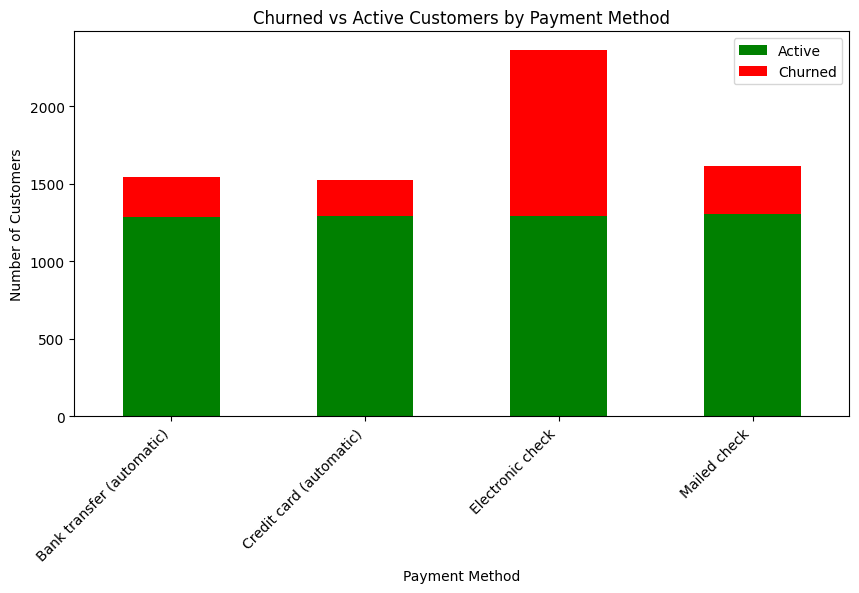

In [15]:
churn_counts_payment = merged_df.groupby(['PaymentMethod', 'Churned']).size().unstack(fill_value=0)
print(display(churn_counts_payment))
churn_counts_payment.plot(
    kind='bar',
    stacked=True,
    color=['green', 'red'],  # red = churned, green = active
    figsize=(10,5)
)

plt.xlabel('Payment Method')
plt.ylabel('Number of Customers')
plt.title('Churned vs Active Customers by Payment Method')
plt.xticks(rotation=45, ha='right')
plt.legend(['Active', 'Churned'])
plt.show()

### Proposed Work Plan

1. Data Understanding & EDA

* Review the structure of each dataset: contract, personal, internet, phone
* Check for missing values, duplicates, and outliers
* Summarize numeric, categorical, and binary features
* Explore distributions and correlations
* Identify trends or patterns that may relate to churn

2. Data Integration & Preprocessing (partially completed)

* Already completed:
* Combined all datasets on customerID
* Converted Yes/No columns to 1/0
* Filled NaN values (InternetService 'None')
* Created churned target column

Remaining:

* One-hot encode categorical features that have not yet been encoded
* Scale numeric features to 0–1

3. Feature Engineering

* Consider creating more features such as:
    * Total number of services used per customer
* Ensure features are numeric and ready for modeling

4. Handling Class Imbalance
* Confirmed: churned is imbalanced (fewer churned customers)
* Strategies to address imbalance:
* Upsampling the minority class (churned)
* SMOTE (synthetic oversampling)
* Use class weights in models (class_weight='balanced')

5. Data Visualization

* Histograms, boxplots, and bar charts for numeric and categorical features
* Explore trends, seasonality, and patterns related to churn
* Examine feature importance after preliminary modeling

6. Modeling & Evaluation

* Split dataset into training and testing sets
* Use DummyClassifier from scikit-learn to set a baseline
* Train baseline models: Logistic Regression, Random Forest, XGBoost
* Evaluate performance using AUC-ROC as the primary metric and accuracy as a secondary metric
* Tune hyperparameters to improve model performance

In [18]:
print(merged_df.columns)

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Churned',
       'EndDate_dt'],
      dtype='object')


### Creating one more feature column for tenure

In [19]:
merged_df['tenure_months'] = (
    pd.to_datetime('2020-02-01') - pd.to_datetime(merged_df['BeginDate'])
).dt.days / 30

In [20]:
print(display(merged_df.sample(10)))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Churned,EndDate_dt,tenure_months
3798,2800-QQUSO,2016-08-01,No,Month-to-month,1,Electronic check,100.30,4222.95,Male,0,...,0,0,0,1,1,1,1,0,NaT,42.633333
5567,8133-ANHHJ,2016-01-01,No,One year,0,Bank transfer (automatic),103.00,5166.2,Female,1,...,1,1,1,1,0,1,1,0,NaT,49.733333
4050,2675-DHUTR,2015-04-01,No,Month-to-month,1,Electronic check,98.90,5780.7,Male,1,...,0,1,0,0,1,1,1,0,NaT,58.900000
1044,3354-OADJP,2019-06-01,No,One year,0,Bank transfer (automatic),54.25,447.75,Female,0,...,1,0,0,1,0,0,0,0,NaT,8.166667
1978,0602-DDUML,2015-05-01,No,Two year,0,Mailed check,69.75,3894.4,Female,0,...,0,1,1,1,1,0,0,0,NaT,57.900000
5351,5649-VUKMC,2018-12-01,2019-12-01 00:00:00,One year,0,Mailed check,95.50,1115.15,Female,0,...,0,0,1,0,1,1,0,1,2019-12-01,14.233333
5158,8092-NLTGF,2014-02-01,No,Two year,0,Bank transfer (automatic),24.75,1777.6,Male,0,...,0,0,0,0,0,0,1,0,NaT,73.033333
4896,3521-MNKLV,2018-02-01,No,Month-to-month,1,Mailed check,49.70,1167.8,Male,0,...,0,0,1,0,0,0,0,0,NaT,24.333333
4633,1820-DJFPH,2014-02-01,No,Two year,1,Bank transfer (automatic),24.05,1709.15,Female,0,...,0,0,0,0,0,0,1,0,NaT,73.033333
2219,1302-UHBDD,2018-06-01,No,Month-to-month,0,Electronic check,89.95,1648.45,Male,1,...,0,0,0,0,1,1,0,0,NaT,20.333333


None


### Dropping unnecesary columns 

In [21]:
merged_df = merged_df.drop(
    columns=['customerID','BeginDate','EndDate','EndDate_dt']
)

display(merged_df.sample(10))

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Churned,tenure_months
474,Month-to-month,1,Electronic check,74.70,74.7,Female,0,1,1,Fiber optic,0,1,0,0,0,0,0,1,3.066667
5561,Month-to-month,0,Electronic check,20.65,20.65,Male,0,0,0,None,0,0,0,0,0,0,0,0,1.033333
5960,One year,0,Electronic check,84.45,4959.15,Female,1,0,0,Fiber optic,0,0,0,0,1,0,1,0,62.933333
5889,Month-to-month,1,Electronic check,50.25,2997.45,Male,1,1,0,DSL,0,1,0,0,1,1,0,0,59.933333
4720,One year,0,Electronic check,102.10,6688.1,Male,1,0,0,Fiber optic,0,0,1,1,1,1,1,0,64.966667
5149,Two year,1,Credit card (automatic),19.20,1123.65,Female,0,0,0,None,0,0,0,0,0,0,0,0,62.933333
7006,Month-to-month,1,Credit card (automatic),104.50,4036.85,Male,0,0,0,Fiber optic,0,1,1,0,1,1,1,1,41.600000
6929,Month-to-month,0,Credit card (automatic),20.05,471.7,Female,0,0,1,None,0,0,0,0,0,0,0,0,25.366667
6212,One year,0,Electronic check,50.75,688.2,Male,0,0,0,DSL,0,0,1,0,1,1,0,0,15.233333
1880,Month-to-month,1,Electronic check,86.00,165.45,Male,0,0,0,Fiber optic,0,0,0,0,0,1,1,1,4.100000


In [23]:
print(merged_df.columns)

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
       'Churned', 'tenure_months'],
      dtype='object')


### Seperate Columns by type

In [24]:
# Binary columns (already 0/1)
binary_cols = [
    'PaperlessBilling', 'SeniorCitizen', 'Partner', 'Dependents',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
]

# Categorical columns (need one-hot encoding)
categorical_cols = [
    'Type', 'PaymentMethod', 'gender', 'InternetService'
]

# Numeric columns (need scaling)
numeric_cols = [
    'MonthlyCharges', 'TotalCharges', 'tenure_months'
]

### Seperate features and targets

In [25]:
features = merged_df.drop(columns='Churned')
target = merged_df['Churned']

In [26]:
features.dtypes

Type                 object
PaperlessBilling      int64
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
gender               object
SeniorCitizen         int64
Partner               int64
Dependents            int64
InternetService      object
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
MultipleLines         int64
tenure_months       float64
dtype: object

In [27]:
features['TotalCharges'] = pd.to_numeric( features['TotalCharges'], errors='coerce' )

### Split Features into Training, Validation, and Test set

In [28]:
# Split features and target into train and temp (70% train, 30% temp)
features_train, features_temp, target_train, target_temp = train_test_split(
    features,
    target,
    test_size=0.30,
    stratify=target,
    random_state=12345
)

features_val, features_test, target_val, target_test = train_test_split(
    features_temp,
    target_temp,
    test_size=0.50,
    stratify=target_temp,
    random_state=12345
)
# Make copies
features_train = features_train.copy()
features_val = features_val.copy()
features_test = features_test.copy()

### Sanity Check 

In [29]:
target_train.mean(), target_val.mean(), target_test.mean()


(0.2653144016227181, 0.26515151515151514, 0.26584673604541154)

### Constructing pipeline

In [30]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', OneHotEncoder(
            drop=None,           # <- important fix
            handle_unknown='ignore'
        ), categorical_cols),
        ('bin', 'passthrough', binary_cols)
    ]
)

### Verifying Set Shapes

In [32]:
print(features_train.shape) # Training set contains 70% of original dataframe rows 
print(target_train.shape)   # Training set contains 70% of original dataframe rows 

# Validation
print(features_val.shape) # Validation set contains 15% of original dataframe rows 
print(target_val.shape)   # Validation set contains 15% of original dataframe rows 

# Test
print(features_test.shape)  # Test set contains 15% of original dataframe rows 
print(target_test.shape)    # Test set contains 15% of original dataframe rows 

(4930, 18)
(4930,)
(1056, 18)
(1056,)
(1057, 18)
(1057,)


### Baseline DummyClassifier model

In [33]:
%%time
# Dummy baseline pipeline
dummy_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', DummyClassifier(strategy='most_frequent'))
])

# Fit
dummy_pipeline.fit(features_train, target_train)

# Predict
pred_val_dummy = dummy_pipeline.predict(features_val)
pred_val_proba_dummy = dummy_pipeline.predict_proba(features_val)[:, 1]

# Metrics
print("Dummy Accuracy:", accuracy_score(target_val, pred_val_dummy))
print("Dummy AUC-ROC:", roc_auc_score(target_val, pred_val_proba_dummy))

Dummy Accuracy: 0.7348484848484849
Dummy AUC-ROC: 0.5
CPU times: user 21.6 ms, sys: 0 ns, total: 21.6 ms
Wall time: 21 ms


### First model (baseline logistic regression)

In [34]:
%%time
# Model_1
baseline_lr_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),  # your ColumnTransformer
    ('model', LogisticRegression(
        solver='liblinear',       # small dataset, liblinear is fine
        random_state=12345
    ))
])

# Fit on training data
baseline_lr_pipeline.fit(features_train, target_train)

# Predict class labels
pred_val_1 = baseline_lr_pipeline.predict(features_val)

# Predict probabilities for AUC-ROC
pred_val_1_proba = baseline_lr_pipeline.predict_proba(features_val)[:, 1]

# Compute metrics
accuracy_1 = accuracy_score(target_val, pred_val_1)
auc_1 = roc_auc_score(target_val, pred_val_1_proba)

print(f"Baseline Logistic Regression - Accuracy: {accuracy_1:.4f}, AUC-ROC: {auc_1:.4f}")

Baseline Logistic Regression - Accuracy: 0.7945, AUC-ROC: 0.8431
CPU times: user 64.4 ms, sys: 26.7 ms, total: 91 ms
Wall time: 34.6 ms


### First model tuned

In [35]:
%%time
# Pipeline with preprocessing + Logistic Regression
pipeline_lr = Pipeline(steps=[
    ('preprocess', preprocessor),  # ColumnTransformer from earlier
    ('model', LogisticRegression(
        solver='liblinear',
        random_state=12345
    ))
])
# Hyperparameter grid
param_grid = {
    'model__class_weight': [None, 'balanced']  # note the 'model__' prefix
}

# Setup GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=pipeline_lr,
    param_grid=param_grid,
    scoring='roc_auc',  # primary metric
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit on training data
grid_search_lr.fit(features_train, target_train)

# Best parameters & cross-validated AUC-ROC
print("Best parameters for tuned Logistic Regression:", grid_search_lr.best_params_)
print("Best CV AUC-ROC:", grid_search_lr.best_score_)

# Evaluate on validation set

best_pipeline_lr = grid_search_lr.best_estimator_

pred_val_best = best_pipeline_lr.predict(features_val)
pred_val_best_proba = best_pipeline_lr.predict_proba(features_val)[:, 1]

accuracy_best = accuracy_score(target_val, pred_val_best)
auc_best = roc_auc_score(target_val, pred_val_best_proba)

print(f"Tuned Logistic Regression - Accuracy: {accuracy_best:.4f}, AUC-ROC: {auc_best:.4f}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters for tuned Logistic Regression: {'model__class_weight': 'balanced'}
Best CV AUC-ROC: 0.8359901609975791
Tuned Logistic Regression - Accuracy: 0.7614, AUC-ROC: 0.8427
CPU times: user 63.5 ms, sys: 90.6 ms, total: 154 ms
Wall time: 1.13 s


### Second Model (baseline RandomForest)

In [36]:
%%time
# Initialize model_2
baseline_rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),      # ColumnTransformer from earlier
    ('model', RandomForestClassifier(
        random_state=12345
    ))
])

# Fit on training data
baseline_rf_pipeline.fit(features_train, target_train)

# Predict class labels
pred_val_2 = baseline_rf_pipeline.predict(features_val)

# Predict probabilities for AUC-ROC
pred_val_2_proba = baseline_rf_pipeline.predict_proba(features_val)[:, 1]

# Compute metrics
accuracy_2 = accuracy_score(target_val, pred_val_2)
auc_2 = roc_auc_score(target_val, pred_val_2_proba)

print(f"Baseline Random Forest - Accuracy: {accuracy_2:.4f}, AUC-ROC: {auc_2:.4f}")

Baseline Random Forest - Accuracy: 0.8400, AUC-ROC: 0.8852
CPU times: user 456 ms, sys: 0 ns, total: 456 ms
Wall time: 455 ms


### Second Model tuned

In [37]:
%%time
# Pipeline with preprocessing + Random Forest
pipeline_rf = Pipeline(steps=[
    ('preprocess', preprocessor),      # ColumnTransformer from earlier
    ('model', RandomForestClassifier(random_state=12345))
])

# Hyperparameter grid
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],   # number of trees
    'model__max_depth': [None, 10, 20, 30],  # max depth of trees
}

# Setup GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    scoring='roc_auc',  # primary metric
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit on training data
grid_search_rf.fit(features_train, target_train)

# Best parameters & cross-validated AUC-ROC
print("Best parameters for tuned Random Forest:", grid_search_rf.best_params_)
print("Best CV AUC-ROC:", grid_search_rf.best_score_)

# Evaluate on validation set
best_pipeline_rf = grid_search_rf.best_estimator_

pred_val_best_2 = best_pipeline_rf.predict(features_val)
pred_val_best_2_proba = best_pipeline_rf.predict_proba(features_val)[:, 1]

accuracy_best_2 = accuracy_score(target_val, pred_val_best_2)
auc_best_2 = roc_auc_score(target_val, pred_val_best_2_proba)

print(f"Tuned Random Forest - Accuracy: {accuracy_best_2:.4f}, AUC-ROC: {auc_best_2:.4f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for tuned Random Forest: {'model__max_depth': 10, 'model__n_estimators': 300}
Best CV AUC-ROC: 0.8736166370549542
Tuned Random Forest - Accuracy: 0.8248, AUC-ROC: 0.8867
CPU times: user 1.2 s, sys: 42.5 ms, total: 1.24 s
Wall time: 12.1 s


### Third model (baseline CatBoost)

In [38]:
%%time
# Baseline CatBoost Pipeline
baseline_cat_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),   # ColumnTransformer from earlier
    ('model', CatBoostClassifier(
        iterations=100,            # small number for quick baseline
        learning_rate=0.1,
        depth=6,
        verbose=0,
        random_state=42
    ))
])

# Fit on training data
baseline_cat_pipeline.fit(features_train, target_train)

# Predict class labels
pred_val_3 = baseline_cat_pipeline.predict(features_val)

# Predict probabilities for AUC-ROC
pred_val_3_proba = baseline_cat_pipeline.predict_proba(features_val)[:, 1]

# Compute metrics
accuracy_3 = accuracy_score(target_val, pred_val_3)
auc_3 = roc_auc_score(target_val, pred_val_3_proba)

print(f"Baseline CatBoost - Accuracy: {accuracy_3:.4f}, AUC-ROC: {auc_3:.4f}")

Baseline CatBoost - Accuracy: 0.8684, AUC-ROC: 0.9186
CPU times: user 697 ms, sys: 264 ms, total: 961 ms
Wall time: 583 ms


### Third model tuned

In [39]:
%%time
# Pipeline with preprocessing + CatBoost
pipeline_cat = Pipeline(steps=[
    ('preprocess', preprocessor),        # ColumnTransformer from earlier
    ('model', CatBoostClassifier(
        verbose=0,
        random_state=12345
    ))
])

# Hyperparameter grid
param_grid_cat = {
    'model__iterations': [200, 400],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [4, 6, 8]
}

# Setup GridSearchCV
grid_search_cat = GridSearchCV(
    estimator=pipeline_cat,
    param_grid=param_grid_cat,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV on training data
grid_search_cat.fit(features_train, target_train)

# Best model & cross-validated AUC-ROC
print("Best CatBoost parameters:", grid_search_cat.best_params_)
print("Best CV AUC-ROC:", grid_search_cat.best_score_)

# Evaluate on validation set
best_pipeline_cat = grid_search_cat.best_estimator_

pred_val_best_3 = best_pipeline_cat.predict(features_val)
pred_val_best_3_proba = best_pipeline_cat.predict_proba(features_val)[:, 1]

accuracy_best_3 = accuracy_score(target_val, pred_val_best_3)
auc_best_3 = roc_auc_score(target_val, pred_val_best_3_proba)

print(f"Tuned CatBoost - Accuracy: {accuracy_best_3:.4f}, AUC-ROC: {auc_best_3:.4f}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best CatBoost parameters: {'model__depth': 4, 'model__iterations': 400, 'model__learning_rate': 0.1}
Best CV AUC-ROC: 0.9270149732820907
Tuned CatBoost - Accuracy: 0.9081, AUC-ROC: 0.9425
CPU times: user 1.96 s, sys: 638 ms, total: 2.6 s
Wall time: 57 s


### Model 4 baseline LGBMC

In [40]:
%%time
# Baseline LGBM Pipeline
baseline_lgbm_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),   # ColumnTransformer from earlier
    ('model', LGBMClassifier(
        n_estimators=50,          # small number for quick baseline
        learning_rate=0.1,
        max_depth=-1,
        random_state=42
    ))
])

# Fit on training data
baseline_lgbm_pipeline.fit(features_train, target_train)

# Predict class labels
pred_val_4 = baseline_lgbm_pipeline.predict(features_val)

# Predict probabilities for AUC-ROC
pred_val_4_proba = baseline_lgbm_pipeline.predict_proba(features_val)[:, 1]

# Compute metrics
accuracy_4 = accuracy_score(target_val, pred_val_4)
auc_4 = roc_auc_score(target_val, pred_val_4_proba)

print(f"Baseline LGBM - Accuracy: {accuracy_4:.4f}, AUC-ROC: {auc_4:.4f}")

Baseline LGBM - Accuracy: 0.8769, AUC-ROC: 0.9251
CPU times: user 672 ms, sys: 21.2 ms, total: 693 ms
Wall time: 327 ms


### Model 4 tuned

In [41]:
%%time
# Pipeline with preprocessing + LGBM
pipeline_lgbm = Pipeline(steps=[
    ('preprocess', preprocessor),      # ColumnTransformer from earlier
    ('model', LGBMClassifier(random_state=12345))
])

# Hyperparameter grid
param_grid_lgbm = {
    'model__n_estimators': [200, 400, 600],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [4, 6, 8],
    'model__num_leaves': [31, 50, 70]
}

# Setup GridSearchCV
grid_search_lgbm = GridSearchCV(
    estimator=pipeline_lgbm,
    param_grid=param_grid_lgbm,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV on training data
grid_search_lgbm.fit(features_train, target_train)

# Best model & cross-validated AUC-ROC
print("Best LGBM parameters:", grid_search_lgbm.best_params_)
print("Best CV AUC-ROC:", grid_search_lgbm.best_score_)

# Evaluate on validation set
best_pipeline_lgbm = grid_search_lgbm.best_estimator_

pred_val_best_4 = best_pipeline_lgbm.predict(features_val)
pred_val_best_4_proba = best_pipeline_lgbm.predict_proba(features_val)[:, 1]

accuracy_best_4 = accuracy_score(target_val, pred_val_best_4)
auc_best_4 = roc_auc_score(target_val, pred_val_best_4_proba)

print(f"Tuned LGBM - Accuracy: {accuracy_best_4:.4f}, AUC-ROC: {auc_best_4:.4f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END ...........................model__class_weight=None; total time=   0.0s
[CV] END .......................model__class_weight=balanced; total time=   0.0s
[CV] END .......................model__class_weight=balanced; total time=   0.0s
[CV] END .....model__max_depth=None, model__n_estimators=100; total time=   0.3s
[CV] END .....model__max_depth=None, model__n_estimators=200; total time=   0.6s
[CV] END .....model__max_depth=None, model__n_estimators=200; total time=   0.6s
[CV] END .....model__max_depth=None, model__n_estimators=300; total time=   0.9s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=   0.3s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=   0.3s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=   0.3s
[CV] END .......model__max_depth=10, model__n_estimators=200; total time=   0.5s
[CV] END .......model__max_depth=10, model__n_e

### Model 5 baseline XGBC

In [42]:
%%time
# Baseline XGBoost Pipeline
baseline_xgb_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),        # ColumnTransformer from earlier
    ('model', XGBClassifier(
        n_estimators=50,
        learning_rate=0.1,
        max_depth=3,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# Fit on training data
baseline_xgb_pipeline.fit(features_train, target_train)

# Predict class labels
pred_val_5 = baseline_xgb_pipeline.predict(features_val)

# Predict probabilities for AUC-ROC
pred_val_5_proba = baseline_xgb_pipeline.predict_proba(features_val)[:, 1]

# Compute metrics
accuracy_5 = accuracy_score(target_val, pred_val_5)
auc_5 = roc_auc_score(target_val, pred_val_5_proba)

print(f"Baseline XGBoost - Accuracy: {accuracy_5:.4f}, AUC-ROC: {auc_5:.4f}")

Baseline XGBoost - Accuracy: 0.8295, AUC-ROC: 0.8929
CPU times: user 1.32 s, sys: 7.52 ms, total: 1.33 s
Wall time: 582 ms


### Model 5 tuned

In [43]:
%%time
# Pipeline with preprocessing + XGBoost
pipeline_xgb = Pipeline(steps=[
    ('preprocess', preprocessor),        # ColumnTransformer from earlier
    ('model', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=12345
    ))
])

# Hyperparameter grid
param_grid_xgb = {
    'model__n_estimators': [50,100],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3]
}

# Setup GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid_xgb,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit on training data
grid_search_xgb.fit(features_train, target_train)

# Best model & cross-validated AUC-ROC
print("Best XGBoost parameters:", grid_search_xgb.best_params_)
print("Best CV AUC-ROC:", grid_search_xgb.best_score_)

# Evaluate on validation set
best_pipeline_xgb = grid_search_xgb.best_estimator_

pred_val_best_5 = best_pipeline_xgb.predict(features_val)
pred_val_best_5_proba = best_pipeline_xgb.predict_proba(features_val)[:, 1]

accuracy_best_5 = accuracy_score(target_val, pred_val_best_5)
auc_best_5 = roc_auc_score(target_val, pred_val_best_5_proba)

print(f"Tuned XGBoost - Accuracy: {accuracy_best_5:.4f}, AUC-ROC: {auc_best_5:.4f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best XGBoost parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Best CV AUC-ROC: 0.9027973662124186
Tuned XGBoost - Accuracy: 0.8523, AUC-ROC: 0.9102
CPU times: user 5.06 s, sys: 82 ms, total: 5.14 s
Wall time: 4min 27s


### Sanity Check on test set

In [44]:
%%time
# Initialize dummy classifier
dummy_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),     # ColumnTransformer from earlier
    ('model', DummyClassifier(strategy="most_frequent"))
])

# Fit on training data
dummy_pipeline.fit(features_train, target_train)

# Predict on test set
pred_test_dummy = dummy_pipeline.predict(features_test)
pred_test_dummy_proba = dummy_pipeline.predict_proba(features_test)[:, 1]

# Evaluate
accuracy_dummy = accuracy_score(target_test, pred_test_dummy)
auc_dummy = roc_auc_score(target_test, pred_test_dummy_proba)

print(f"DummyClassifier (Sanity Check) - Accuracy: {accuracy_dummy:.4f}, AUC-ROC: {auc_dummy:.4f}")

DummyClassifier (Sanity Check) - Accuracy: 0.7342, AUC-ROC: 0.5000
CPU times: user 21.8 ms, sys: 0 ns, total: 21.8 ms
Wall time: 21.1 ms


### Test Set on best model (Catboost)

In [45]:
%%time
# Use tuned CatBoost pipeline
# Predict on test set
pred_test_cat = best_pipeline_cat.predict(features_test)
pred_test_cat_proba = best_pipeline_cat.predict_proba(features_test)[:, 1]

# Compute metrics
accuracy_test = accuracy_score(target_test, pred_test_cat)
auc_test = roc_auc_score(target_test, pred_test_cat_proba)

print(f"Tuned CatBoost on Test Set - Accuracy: {accuracy_test:.4f}, AUC-ROC: {auc_test:.4f}")

# Confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(target_test, pred_test_cat))

print("\nClassification Report:")

Tuned CatBoost on Test Set - Accuracy: 0.8865, AUC-ROC: 0.9208

Confusion Matrix:
[[743  33]
 [ 87 194]]

Classification Report:
CPU times: user 16.1 ms, sys: 11.6 ms, total: 27.8 ms
Wall time: 24.2 ms


### Conclusion

The customer churn dataset was preprocessed using a pipeline with one-hot encoding for categorical features, scaling for numeric features, and passthrough for binary features, ensuring consistent treatment across all models. The data was split into stratified training (70%), validation (15%), and test (15%) sets to preserve the class distribution for reliable evaluation. A DummyClassifier was used as a baseline to validate the pipeline and confirm that predictive models outperform random guessing.

Multiple classification models were trained and tuned using AUC-ROC as the primary metric and accuracy as a secondary metric. While models such as LightGBM, XGBoost, and Random Forest all showed strong predictive ability, CatBoost (Model 3) demonstrated the best performance on the held-out test set, achieving an accuracy of 0.8865 and an AUC-ROC of 0.9208. Although XGBoost and LightGBM also delivered strong validation performance, tuning XGBoost was considerably more time-intensive, making CatBoost a more practical choice. Its combination of high predictive performance, computational efficiency, and ease of tuning makes it the recommended model for customer churn prediction in this project.

### Final Project: Solution Report


1. Steps Performed and Steps Skipped

All major steps of the project plan were completed. The dataset was merged, cleaned, and explored to understand customer behavior and churn patterns. Feature engineering and preprocessing were performed using a scikit-learn pipeline to ensure consistency and prevent data leakage. The data was split into stratified training (70%), validation (15%), and test (15%) sets to account for class imbalance.

Multiple classification models were trained and evaluated, including Logistic Regression, Random Forest, CatBoost, LightGBM, and XGBoost. Hyperparameter tuning was performed using cross-validated grid search with AUC-ROC as the primary evaluation metric.

No major steps were skipped. However, extensive hyperparameter tuning for XGBoost was limited due to its high computational cost and long training times. Since other models achieved comparable or better performance with significantly lower training time, further tuning of XGBoost was not pursued.

2. Difficulties Encountered and How They Were Resolved

Several challenges were encountered during the project:

Class imbalance in the churn target initially led to unreliable evaluation results. This was resolved by using stratified data splits and adjusting model parameters such as class weights where appropriate.

Data leakage risk occurred when encoding and scaling were applied before splitting the data. This was resolved by implementing a preprocessing pipeline that fits transformers only on the training set and applies them consistently to validation and test sets.

Handling unseen categories in categorical features caused errors during validation and testing. This was addressed by configuring the OneHotEncoder with handle_unknown='ignore'.

Computational cost during model tuning required careful trade-offs between performance and efficiency, leading to selective tuning for the most promising models.

3. Key Steps to Solving the Task

The most important steps in successfully solving the task were:

Implementing a robust preprocessing pipeline to handle missing values, scaling, and categorical encoding without data leakage

Using stratified splits to ensure consistent class distributions across datasets

Establishing a baseline using a DummyClassifier to validate the modeling pipeline

Comparing multiple models using consistent evaluation metrics

Selecting the final model based on both predictive performance and generalization to unseen data

4. Final Model and Quality Score

The final selected model was a tuned CatBoost classifier. It demonstrated the best overall generalization performance on the held-out test set:

Test AUC-ROC: 0.9208

Test Accuracy: 0.8865

This model provided strong predictive power while remaining computationally efficient, making it well-suited for real-world deployment in customer churn prediction and retention strategy development.